In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import cv2
%matplotlib inline

In [2]:
from glob import glob

In [3]:
import keras
import keras.backend as k

Using TensorFlow backend.


## Data Overview

In [4]:
trainImgDf=pd.read_csv('MURA-v1.1/train_image_paths.csv',header=None,names=['path'],dtype=str)
trainLabelDf=pd.read_csv('MURA-v1.1/train_labeled_studies.csv',header=None,names=['path','label'],dtype=str)
testImgDf=pd.read_csv('MURA-v1.1/valid_image_paths.csv',header=None,names=['path'],dtype=str)
testLabelDf=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv',header=None,names=['path','label'],dtype=str)

### there are 4 csv files dedicated to the store the path of the image and the binary label of each study. The label is either 0 or 1, indicating the study is abnormal or normal

In [5]:
# number of images
trainImgDf.shape

(36808, 1)

In [6]:
trainImgDf.head(10)

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study...


In [7]:
# number of labeled cases
trainLabelDf.shape

(13457, 2)

In the training set, the Mura data contains 13457 labeled cases, 36808 images. This indicates some cases may have more than 1 images.

In [8]:
# The binary output
trainLabelDf['label'].value_counts()

0    8280
1    5177
Name: label, dtype: int64

In [9]:
testImgDf.head(10)

,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
5,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
6,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
7,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
8,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...


In [10]:
# number of test images
testImgDf.shape

(3197, 1)

In [11]:
# number of cases
testLabelDf.shape

(1199, 2)

## adding additional columns by extrating information from the path for future analysis

In [12]:
trainLabelDf['part']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
trainLabelDf['patientNum']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[3]))
trainLabelDf['studyNum']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
trainLabelDf['caseNum']=trainLabelDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)



testLabelDf['part']=testLabelDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
testLabelDf['patientNum']=testLabelDf['path'].apply(lambda x: str(x.split('/')[3]))
testLabelDf['studyNum']=testLabelDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
testLabelDf['caseNum']=testLabelDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)

In [13]:
trainLabelDf.head(10)

,path,label,part,patientNum,studyNum,caseNum
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,patient00001,study1,patient00001study1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,patient00002,study1,patient00002study1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,SHOULDER,patient00003,study1,patient00003study1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,SHOULDER,patient00004,study1,patient00004study1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,SHOULDER,patient00005,study1,patient00005study1
5,MURA-v1.1/train/XR_SHOULDER/patient00006/study...,1,SHOULDER,patient00006,study1,patient00006study1
6,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,1,SHOULDER,patient00007,study1,patient00007study1
7,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,0,SHOULDER,patient00007,study2,patient00007study2
8,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1,SHOULDER,patient00008,study1,patient00008study1
9,MURA-v1.1/train/XR_SHOULDER/patient00009/study...,1,SHOULDER,patient00009,study1,patient00009study1


In [14]:
testLabelDf.head(10)

,path,label,part,patientNum,studyNum,caseNum
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,patient11185,study1,patient11185study1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,patient11186,study1,patient11186study1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,patient11186,study2,patient11186study2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,patient11186,study3,patient11186study3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,patient11187,study1,patient11187study1
5,MURA-v1.1/valid/XR_WRIST/patient11188/study1_p...,1,WRIST,patient11188,study1,patient11188study1
6,MURA-v1.1/valid/XR_WRIST/patient11189/study1_p...,1,WRIST,patient11189,study1,patient11189study1
7,MURA-v1.1/valid/XR_WRIST/patient11190/study1_p...,1,WRIST,patient11190,study1,patient11190study1
8,MURA-v1.1/valid/XR_WRIST/patient11191/study1_p...,1,WRIST,patient11191,study1,patient11191study1
9,MURA-v1.1/valid/XR_WRIST/patient11192/study1_p...,1,WRIST,patient11192,study1,patient11192study1


## the number of patient in the training/test set  

In [15]:
len(trainLabelDf['patientNum'].unique())

11184

In [16]:
len(testLabelDf['patientNum'].unique())

783

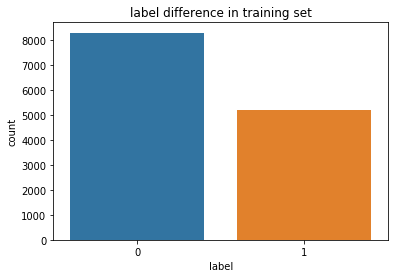

In [17]:
plt.title('label difference in training set')
sns.countplot(x=trainLabelDf['label'])

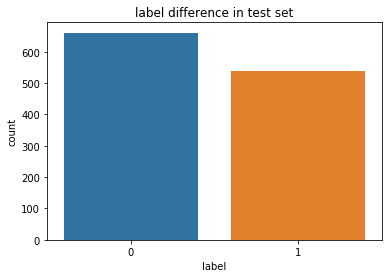

In [18]:
plt.title('label difference in test set')
sns.countplot(x=testLabelDf['label'])

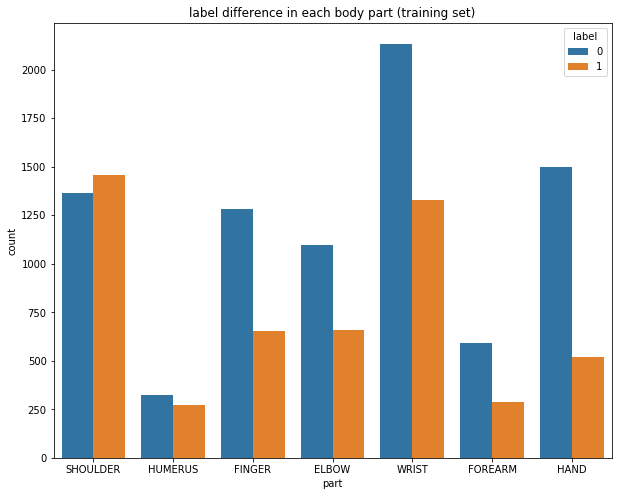

In [19]:
plt.figure(figsize=(10,8))
plt.title('label difference in each body part (training set)')
sns.countplot(data=trainLabelDf,x='part',hue='label')

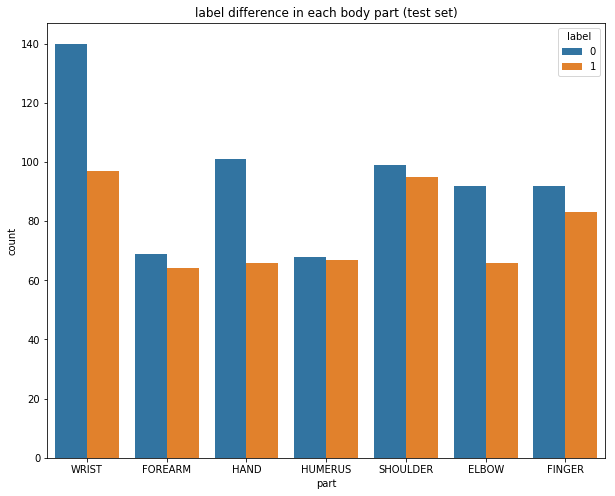

In [20]:
plt.figure(figsize=(10,8))
plt.title('label difference in each body part (test set)')
sns.countplot(data=testLabelDf,x='part',hue='label')

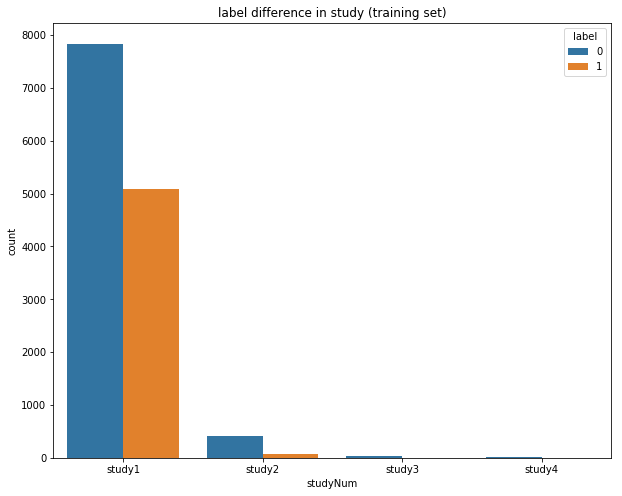

In [21]:
plt.figure(figsize=(10,8))
plt.title('label difference in study (training set)')
sns.countplot(data=trainLabelDf,x='studyNum',hue='label')

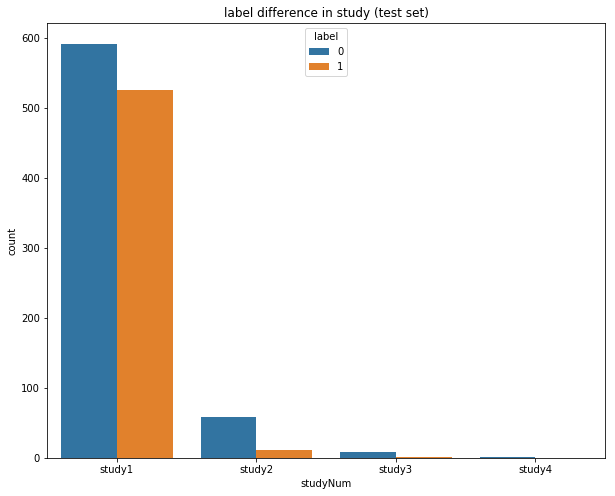

In [22]:
plt.figure(figsize=(10,8))
plt.title('label difference in study (test set)')
sns.countplot(data=testLabelDf,x='studyNum',hue='label')

### Plot a sample radiographs from training and validation set

(512, 380, 3) ['XR_SHOULDER', 'study1_positive']


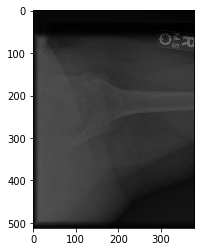

In [23]:
path=trainImgDf.values[0][0]
img=cv2.imread(path)
plt.imshow(img)
print(img.shape,path.split('/')[2:5:2])

(512, 405, 3) ['XR_HAND', 'study1_negative']


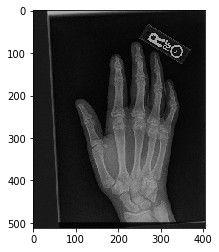

In [24]:
path=trainImgDf.values[-1][0]
img=cv2.imread(path)
plt.imshow(img)
print(img.shape,path.split('/')[2:5:2])

Patients might have multiple studies for a given study type, like a patient may have two studies for wrist, independent of each other. <br> Let's have a look at such cases, **NOTE** here study count = number of patients which have same number of studies

In [25]:
trainImgDf['part']=trainImgDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
trainImgDf['patientNum']=trainImgDf['path'].apply(lambda x: str(x.split('/')[3]))
trainImgDf['studyNum']=trainImgDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
trainImgDf['caseNum']=trainImgDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)



testImgDf['part']=testImgDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
testImgDf['patientNum']=testImgDf['path'].apply(lambda x: str(x.split('/')[3]))
testImgDf['studyNum']=testImgDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
testImgDf['caseNum']=testImgDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)

In [26]:
trainImgDf.head()

,path,part,patientNum,studyNum,caseNum
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,patient00002study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,patient00002study1


In [27]:
trainImgDf['part'].value_counts()

WRIST       9752
SHOULDER    8379
HAND        5543
FINGER      5106
ELBOW       4931
FOREARM     1825
HUMERUS     1272
Name: part, dtype: int64

In [28]:
testImgDf.head()

,path,part,patientNum,studyNum,caseNum
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,WRIST,patient11186,study1,patient11186study1


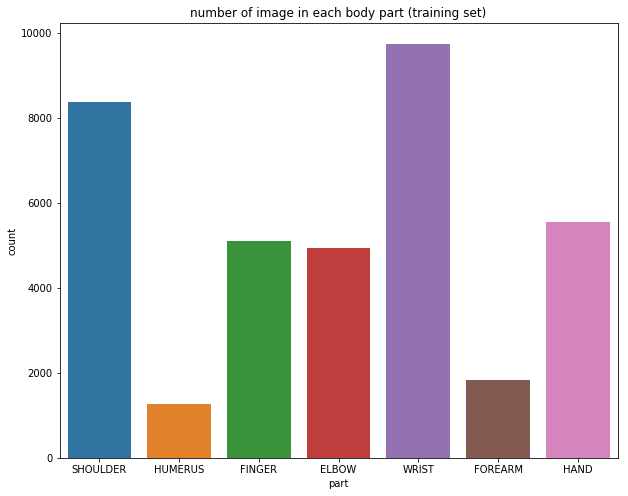

In [29]:
plt.figure(figsize=(10,8))
plt.title('number of image in each body part (training set)')
sns.countplot(data=trainImgDf,x='part')

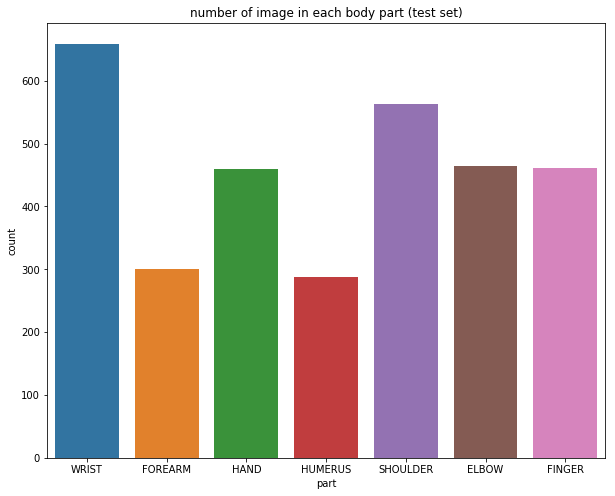

In [30]:
plt.figure(figsize=(10,8))
plt.title('number of image in each body part (test set)')
sns.countplot(data=testImgDf,x='part')

### within each body type, we display the numeber of images per study cases 

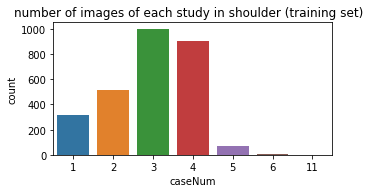

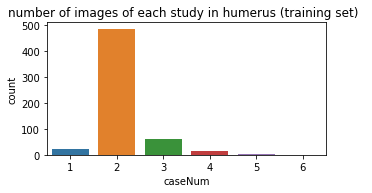

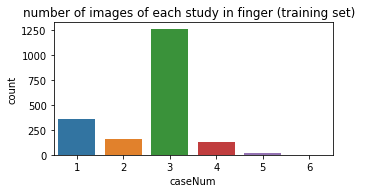

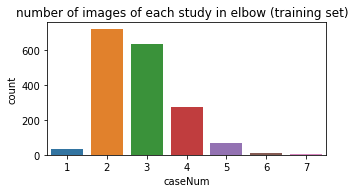

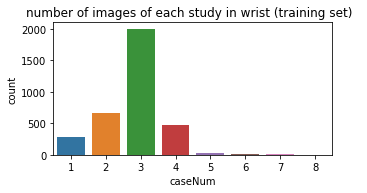

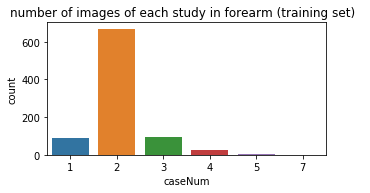

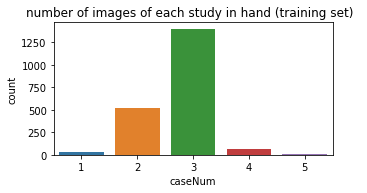

In [31]:
bodyType = trainImgDf['part'].unique()
for idx,body in enumerate(bodyType):
    plt.figure(figsize=(5,20))
    ax = plt.subplot(711+idx)
    bodyCase = trainImgDf[trainImgDf['part'] == body]
    plt.title('number of images of each study in %s (training set)  ' % body.lower())
    sns.countplot(bodyCase['caseNum'].value_counts())

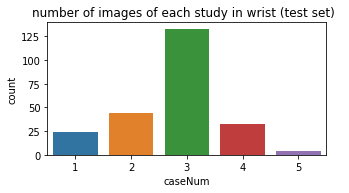

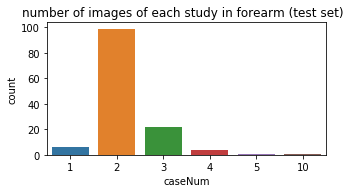

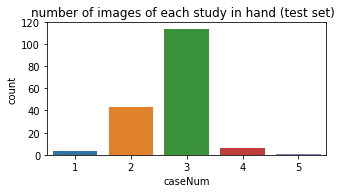

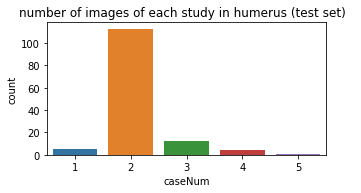

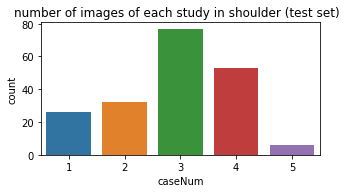

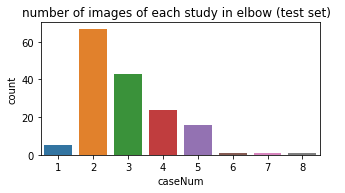

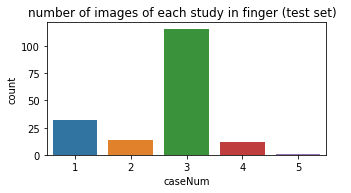

In [32]:
bodyType = testImgDf['part'].unique()
for idx,body in enumerate(bodyType):
    plt.figure(figsize=(5,20))
    ax = plt.subplot(711+idx)
    bodyCase = testImgDf[testImgDf['part'] == body]
    plt.title('number of images of each study in %s (test set)  ' % body.lower())
    sns.countplot(bodyCase['caseNum'].value_counts())

most of the study cases have more than one images, which will make the predication more difficult. The spread of image is related to the body type.

## Train CNN for the images of hand

##### Extract only the dataframe for hands

In [164]:
trainLabelDf['label'][0:5]

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: object

In [165]:
# extract part of 'HAND' for training

train_hand_img = trainImgDf[trainImgDf['part'] == 'WRIST']
train_hand_label = trainLabelDf[trainLabelDf['part'] == 'WRIST']
test_hand_img = testImgDf[testImgDf['part'] == 'WRIST']
test_hand_label = testLabelDf[testLabelDf['part'] == 'WRIST']

In [166]:
train_hand_label.count()

path          3460
label         3460
part          3460
patientNum    3460
studyNum      3460
caseNum       3460
dtype: int64

### Prepocessing 

   1. Resizing the image with same resolution (use one channel)
   2. Normalization (in Keras)
   3. Taking the label of each case to the images

###### Output


(224, 224)

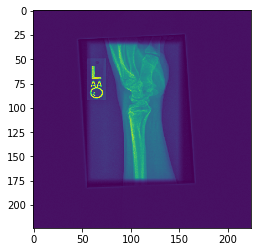

In [174]:
Path=trainImgDf[trainImgDf['part'] == 'WRIST'].values[-2][0]
img=cv2.imread(Path)
plt.imshow(img[:,:,2])    #the color is not important to distinguish
img[:,:,2].shape   ## just a test to make sure they give same x-ray images (independant of color)

In [186]:
## function to resize and normalize the image

def resize_(Path):
    img=cv2.imread(Path)
    
    # Use one channel (or grayscale)
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sizing down the resolution. (224, 224) is used in the article
    img=cv2.resize(img,(150,150))
    
    # 
    img=np.array(img)
   # img=img
    
    return img

In [187]:
resize_(trainLabelDf['path'][1]+'image1.png').shape

#np.max(resize_and_normalization(trainLabelDf['path'][1]+'image1.png'))

(150, 150, 3)

##### Average the images and save it into one file

In [188]:
my_dict = {}
for i in train_hand_label.index:
    folder = train_hand_label['path'].loc[i]
    labels = train_hand_label['label'].loc[i]
    pic = glob(folder+'*.png')
    for filename in pic:
        my_dict[filename] = labels
        im = resize_(filename)              # run once
        cv2.imwrite(filename, im)           # run once

In [189]:
train_hand_image = pd.DataFrame()
train_hand_image['path'] = my_dict.keys()
train_hand_image['label'] = my_dict.values()

In [190]:
train_hand_image.count()

path     9752
label    9752
dtype: int64

In [191]:
# perform same operation for test dataset

my_dict = {}
for i in test_hand_label.index:
    folder = test_hand_label['path'].loc[i]
    labels = test_hand_label['label'].loc[i]
    pic = glob(folder+'*.png')
    for filename in pic:
        my_dict[filename] = labels
        im = resize_(filename)       # run once
        cv2.imwrite(filename, im)    # run once

test_hand_image = pd.DataFrame()
test_hand_image['path'] = my_dict.keys()
test_hand_image['label'] = my_dict.values()

In [192]:
test_hand_image.count()

path     659
label    659
dtype: int64

In [193]:
trainLabelDf['path'][1]

'MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/'

### Building CNN using Keras

In [180]:
## image size (sizing down the original image) VGG
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model

input_shape = (224, 224, 3)
vgg16 = VGG16(weights='imagenet', include_top=True, input_shape=input_shape)
x = Dense(1, activation='sigmoid', name='predictions')(vgg16.layers[-2].output)
model = Model(input=vgg16.input, output=x)

## ResNet
#resnet50 = ResNet50(weights=None, include_top=True, input_shape=input_shape)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  if sys.path[0] == '':


In [223]:
## CNN architecture (variation of LeNet)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
input_shape = (150, 150, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc', 'mse'])


In [224]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc', 'mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_45 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_46 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 34, 34, 64)        18496     
__________

##### Data Augmentation

In [225]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    rotation_range=25,
    fill_mode='nearest',
)

datagen1=ImageDataGenerator(

    rescale=1./255,
)

In [226]:
batch_size = 32

In [227]:
IMG_SIZE = (150,150)
train_generator = datagen.flow_from_dataframe(
    train_hand_image,x_col='path',
    y_col = 'label',
    target_size= IMG_SIZE,
    class_mode='binary',
    batch_size= batch_size)


test_generator = datagen1.flow_from_dataframe(
    test_hand_image,x_col='path',
    y_col = 'label',
    target_size= IMG_SIZE,
    class_mode='binary',
    batch_size= batch_size)

Found 9752 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.


In [228]:
epochs = 100
nb_train_samples = train_hand_image['label'].count()
nb_test_samples = test_hand_image['label'].count()

#train the module
model_history = model.fit_generator(train_generator, 
                      steps_per_epoch=nb_train_samples // batch_size,    
                    epochs=epochs, validation_data = test_generator, validation_steps =nb_test_samples//batch_size )

Epoch 1/100
304/304 [==============================] - 158s 519ms/step - loss: 0.6577 - acc: 0.6075 - mean_squared_error: 0.2326 - val_loss: 0.6601 - val_acc: 0.5891 - val_mean_squared_error: 0.2340
Epoch 2/100
304/304 [==============================] - 162s 532ms/step - loss: 0.6399 - acc: 0.6296 - mean_squared_error: 0.2242 - val_loss: 0.6615 - val_acc: 0.5789 - val_mean_squared_error: 0.2343
Epoch 3/100
304/304 [==============================] - 161s 531ms/step - loss: 0.6287 - acc: 0.6460 - mean_squared_error: 0.2194 - val_loss: 0.6532 - val_acc: 0.6284 - val_mean_squared_error: 0.2282
Epoch 4/100
304/304 [==============================] - 155s 510ms/step - loss: 0.6187 - acc: 0.6579 - mean_squared_error: 0.2151 - val_loss: 0.6401 - val_acc: 0.6332 - val_mean_squared_error: 0.2248
Epoch 5/100
304/304 [==============================] - 155s 510ms/step - loss: 0.6183 - acc: 0.6519 - mean_squared_error: 0.2151 - val_loss: 0.6391 - val_acc: 0.6124 - val_mean_squared_error: 0.2252
Epoch

304/304 [==============================] - 152s 501ms/step - loss: 0.4891 - acc: 0.7587 - mean_squared_error: 0.1611 - val_loss: 0.5751 - val_acc: 0.7081 - val_mean_squared_error: 0.1899
Epoch 43/100
304/304 [==============================] - 157s 517ms/step - loss: 0.4864 - acc: 0.7636 - mean_squared_error: 0.1600 - val_loss: 0.5372 - val_acc: 0.7312 - val_mean_squared_error: 0.1788
Epoch 44/100
304/304 [==============================] - 178s 585ms/step - loss: 0.4835 - acc: 0.7663 - mean_squared_error: 0.1594 - val_loss: 0.5206 - val_acc: 0.7177 - val_mean_squared_error: 0.1729
Epoch 45/100
304/304 [==============================] - 148s 488ms/step - loss: 0.4861 - acc: 0.7650 - mean_squared_error: 0.1590 - val_loss: 0.5181 - val_acc: 0.7400 - val_mean_squared_error: 0.1716
Epoch 46/100
304/304 [==============================] - 157s 515ms/step - loss: 0.4779 - acc: 0.7686 - mean_squared_error: 0.1571 - val_loss: 0.5012 - val_acc: 0.7241 - val_mean_squared_error: 0.1671
Epoch 47/100


304/304 [==============================] - 157s 518ms/step - loss: 0.4408 - acc: 0.7914 - mean_squared_error: 0.1430 - val_loss: 0.5380 - val_acc: 0.7576 - val_mean_squared_error: 0.1711
Epoch 84/100
304/304 [==============================] - 147s 484ms/step - loss: 0.4462 - acc: 0.7870 - mean_squared_error: 0.1450 - val_loss: 0.5080 - val_acc: 0.7576 - val_mean_squared_error: 0.1658
Epoch 85/100
304/304 [==============================] - 151s 497ms/step - loss: 0.4363 - acc: 0.7905 - mean_squared_error: 0.1429 - val_loss: 0.5158 - val_acc: 0.7484 - val_mean_squared_error: 0.1696
Epoch 86/100
304/304 [==============================] - 149s 491ms/step - loss: 0.4426 - acc: 0.7910 - mean_squared_error: 0.1428 - val_loss: 0.4970 - val_acc: 0.7640 - val_mean_squared_error: 0.1608
Epoch 87/100
304/304 [==============================] - 149s 492ms/step - loss: 0.4359 - acc: 0.7941 - mean_squared_error: 0.1415 - val_loss: 0.5328 - val_acc: 0.7464 - val_mean_squared_error: 0.1751
Epoch 88/100


In [52]:
#model.fit_generator

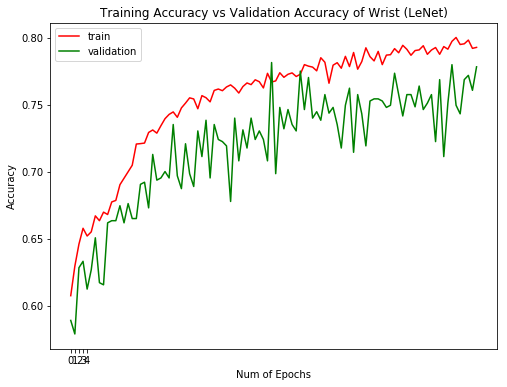

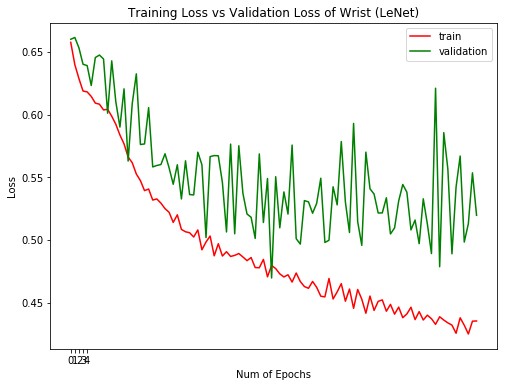

In [229]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy of Wrist (LeNet)")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 5, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss of Wrist (LeNet)")
plt.legend(['train','validation'])

 
plt.show()

In [230]:
ev=model.evaluate_generator(test_generator, steps=(nb_test_samples//batch_size)+1, 
                            workers=0,use_multiprocessing=False)


In [232]:
ev[1]

0.7936267073129124

In [231]:
ev

[0.5151864934673078, 0.7936267073129124, 0.15456193084058342]